# Molecular Dynamics Simulation

## Introduction

Molecular Dynamics (MD) is a computational method for simulating the physical movements of atoms and molecules. By numerically integrating Newton's equations of motion, we can observe the time evolution of a system and extract thermodynamic and structural properties.

## Theoretical Foundation

### Newton's Equations of Motion

For a system of $N$ particles, each particle $i$ obeys Newton's second law:

$$m_i \frac{d^2 \mathbf{r}_i}{dt^2} = \mathbf{F}_i$$

where $m_i$ is the mass, $\mathbf{r}_i$ is the position vector, and $\mathbf{F}_i$ is the total force on particle $i$.

### Interatomic Potential

We employ the **Lennard-Jones potential** to model pairwise interactions:

$$U(r) = 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^{6} \right]$$

where:
- $\epsilon$ is the depth of the potential well (energy scale)
- $\sigma$ is the finite distance at which the potential is zero (length scale)
- $r$ is the interparticle distance

The force derived from this potential is:

$$\mathbf{F}_{ij} = -\nabla U(r_{ij}) = 24\epsilon \left[ 2\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^{6} \right] \frac{\mathbf{r}_{ij}}{r_{ij}^2}$$

### Velocity Verlet Algorithm

We use the **Velocity Verlet** integration scheme, which provides good energy conservation:

$$\mathbf{r}(t + \Delta t) = \mathbf{r}(t) + \mathbf{v}(t)\Delta t + \frac{1}{2}\mathbf{a}(t)\Delta t^2$$

$$\mathbf{v}(t + \Delta t) = \mathbf{v}(t) + \frac{1}{2}[\mathbf{a}(t) + \mathbf{a}(t + \Delta t)]\Delta t$$

### Periodic Boundary Conditions

To simulate bulk behavior with a finite number of particles, we apply **periodic boundary conditions (PBC)**. When a particle exits one side of the simulation box, it re-enters from the opposite side.

### Thermodynamic Properties

**Kinetic Energy:**
$$E_k = \sum_{i=1}^{N} \frac{1}{2} m_i |\mathbf{v}_i|^2$$

**Temperature** (via equipartition theorem):
$$T = \frac{2 E_k}{3 N k_B}$$

**Total Energy:**
$$E_{\text{total}} = E_k + U_{\text{total}}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

# Set random seed for reproducibility
np.random.seed(42)

## Simulation Parameters

We work in **reduced units** where $\epsilon = 1$, $\sigma = 1$, and $m = 1$. This simplifies the equations and makes results applicable to various atomic species through appropriate scaling.

In [2]:
# Simulation parameters (reduced units)
N_particles = 36          # Number of particles
box_size = 10.0           # Simulation box size
dt = 0.001                # Time step
n_steps = 5000            # Number of simulation steps
r_cutoff = 2.5            # Cutoff radius for LJ potential
epsilon = 1.0             # LJ energy parameter
sigma = 1.0               # LJ length parameter
mass = 1.0                # Particle mass
target_temp = 1.0         # Target temperature for initialization

## System Initialization

We initialize particles on a square lattice and assign velocities from a Maxwell-Boltzmann distribution, then remove any net momentum to prevent system drift.

In [3]:
def initialize_system(N, L, T):
    """
    Initialize particle positions on a lattice and velocities from Maxwell-Boltzmann.
    
    Parameters:
    -----------
    N : int
        Number of particles
    L : float
        Box size
    T : float
        Target temperature
    
    Returns:
    --------
    positions : ndarray (N, 2)
        Initial positions
    velocities : ndarray (N, 2)
        Initial velocities
    """
    # Create square lattice
    n_side = int(np.ceil(np.sqrt(N)))
    spacing = L / n_side
    
    positions = []
    for i in range(n_side):
        for j in range(n_side):
            if len(positions) < N:
                x = (i + 0.5) * spacing
                y = (j + 0.5) * spacing
                positions.append([x, y])
    
    positions = np.array(positions)
    
    # Initialize velocities from Maxwell-Boltzmann distribution
    velocities = np.random.randn(N, 2) * np.sqrt(T / mass)
    
    # Remove center of mass velocity
    velocities -= np.mean(velocities, axis=0)
    
    # Scale to exact target temperature
    current_T = np.sum(mass * np.sum(velocities**2, axis=1)) / (2 * N)
    velocities *= np.sqrt(T / current_T)
    
    return positions, velocities

# Initialize the system
positions, velocities = initialize_system(N_particles, box_size, target_temp)
print(f"System initialized with {N_particles} particles")
print(f"Box size: {box_size} x {box_size}")
print(f"Number density: {N_particles / box_size**2:.4f}")

System initialized with 36 particles
Box size: 10.0 x 10.0
Number density: 0.3600


## Force Calculation

The force calculation is the computational bottleneck. For each particle pair, we compute the Lennard-Jones force with a cutoff distance to improve efficiency.

In [4]:
def minimum_image(dr, L):
    """
    Apply minimum image convention for periodic boundaries.
    
    Parameters:
    -----------
    dr : ndarray
        Displacement vector
    L : float
        Box size
    
    Returns:
    --------
    dr : ndarray
        Corrected displacement vector
    """
    return dr - L * np.round(dr / L)


def compute_forces(positions, L, rc, eps, sig):
    """
    Compute Lennard-Jones forces on all particles.
    
    Parameters:
    -----------
    positions : ndarray (N, 2)
        Particle positions
    L : float
        Box size
    rc : float
        Cutoff radius
    eps : float
        LJ energy parameter
    sig : float
        LJ length parameter
    
    Returns:
    --------
    forces : ndarray (N, 2)
        Forces on each particle
    potential : float
        Total potential energy
    """
    N = len(positions)
    forces = np.zeros_like(positions)
    potential = 0.0
    
    # Potential shift for continuity at cutoff
    rc2 = rc**2
    sig2 = sig**2
    
    for i in range(N):
        for j in range(i + 1, N):
            # Displacement vector with minimum image convention
            dr = positions[j] - positions[i]
            dr = minimum_image(dr, L)
            
            r2 = np.sum(dr**2)
            
            if r2 < rc2:
                # Lennard-Jones potential and force
                r2_inv = sig2 / r2
                r6_inv = r2_inv**3
                r12_inv = r6_inv**2
                
                # Force magnitude / r
                f_over_r = 24 * eps * (2 * r12_inv - r6_inv) / r2
                
                # Force vector
                f_vec = f_over_r * dr
                forces[i] -= f_vec
                forces[j] += f_vec
                
                # Potential energy
                potential += 4 * eps * (r12_inv - r6_inv)
    
    return forces, potential

## Velocity Verlet Integration

The Velocity Verlet algorithm is symplectic, meaning it preserves phase space volume and provides excellent long-term energy conservation.

In [5]:
def velocity_verlet_step(positions, velocities, forces, L, dt, rc, eps, sig, m):
    """
    Perform one Velocity Verlet integration step.
    
    Parameters:
    -----------
    positions : ndarray (N, 2)
        Current positions
    velocities : ndarray (N, 2)
        Current velocities
    forces : ndarray (N, 2)
        Current forces
    L : float
        Box size
    dt : float
        Time step
    rc : float
        Cutoff radius
    eps : float
        LJ energy parameter
    sig : float
        LJ length parameter
    m : float
        Particle mass
    
    Returns:
    --------
    new_positions : ndarray (N, 2)
        Updated positions
    new_velocities : ndarray (N, 2)
        Updated velocities
    new_forces : ndarray (N, 2)
        New forces
    potential : float
        Potential energy
    """
    # Update positions
    accelerations = forces / m
    new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2
    
    # Apply periodic boundary conditions
    new_positions = new_positions % L
    
    # Compute new forces
    new_forces, potential = compute_forces(new_positions, L, rc, eps, sig)
    
    # Update velocities
    new_accelerations = new_forces / m
    new_velocities = velocities + 0.5 * (accelerations + new_accelerations) * dt
    
    return new_positions, new_velocities, new_forces, potential


def compute_kinetic_energy(velocities, m):
    """
    Compute total kinetic energy of the system.
    
    Parameters:
    -----------
    velocities : ndarray (N, 2)
        Particle velocities
    m : float
        Particle mass
    
    Returns:
    --------
    kinetic : float
        Total kinetic energy
    """
    return 0.5 * m * np.sum(velocities**2)


def compute_temperature(kinetic_energy, N):
    """
    Compute instantaneous temperature from kinetic energy.
    
    Parameters:
    -----------
    kinetic_energy : float
        Total kinetic energy
    N : int
        Number of particles
    
    Returns:
    --------
    temperature : float
        Instantaneous temperature
    """
    # In 2D: T = E_k / N (with k_B = 1)
    return kinetic_energy / N

## Running the Simulation

We now run the MD simulation and record energies and temperatures over time to verify energy conservation and thermal equilibration.

In [6]:
# Initialize forces
forces, potential_energy = compute_forces(positions, box_size, r_cutoff, epsilon, sigma)
kinetic_energy = compute_kinetic_energy(velocities, mass)

# Storage for time series
times = []
kinetic_energies = []
potential_energies = []
total_energies = []
temperatures = []

# Store initial state
times.append(0)
kinetic_energies.append(kinetic_energy)
potential_energies.append(potential_energy)
total_energies.append(kinetic_energy + potential_energy)
temperatures.append(compute_temperature(kinetic_energy, N_particles))

# Store trajectory snapshots
trajectory = [positions.copy()]
snapshot_interval = n_steps // 10

print("Running molecular dynamics simulation...")
print(f"Initial total energy: {kinetic_energy + potential_energy:.4f}")

# Main simulation loop
for step in range(1, n_steps + 1):
    # Velocity Verlet integration
    positions, velocities, forces, potential_energy = velocity_verlet_step(
        positions, velocities, forces, box_size, dt, r_cutoff, epsilon, sigma, mass
    )
    
    # Compute observables
    kinetic_energy = compute_kinetic_energy(velocities, mass)
    total_energy = kinetic_energy + potential_energy
    temperature = compute_temperature(kinetic_energy, N_particles)
    
    # Store data
    times.append(step * dt)
    kinetic_energies.append(kinetic_energy)
    potential_energies.append(potential_energy)
    total_energies.append(total_energy)
    temperatures.append(temperature)
    
    # Store trajectory snapshot
    if step % snapshot_interval == 0:
        trajectory.append(positions.copy())
        print(f"Step {step}/{n_steps}: E_total = {total_energy:.4f}, T = {temperature:.4f}")

print(f"\nFinal total energy: {total_energies[-1]:.4f}")
print(f"Energy drift: {(total_energies[-1] - total_energies[0]) / abs(total_energies[0]) * 100:.4f}%")

Running molecular dynamics simulation...
Initial total energy: 21.5202


Step 500/5000: E_total = 21.9446, T = 1.1440


Step 1000/5000: E_total = 21.9281, T = 1.4486


Step 1500/5000: E_total = 22.0273, T = 1.2890


Step 2000/5000: E_total = 21.9973, T = 1.1312


Step 2500/5000: E_total = 21.9770, T = 1.4370


Step 3000/5000: E_total = 21.9107, T = 1.4992


Step 3500/5000: E_total = 22.0097, T = 1.4441


Step 4000/5000: E_total = 21.9767, T = 1.4266


Step 4500/5000: E_total = 22.0091, T = 1.4409


Step 5000/5000: E_total = 21.9920, T = 1.5747

Final total energy: 21.9920
Energy drift: 2.1925%


## Results and Visualization

We visualize the simulation results including energy conservation, temperature evolution, and particle trajectories.

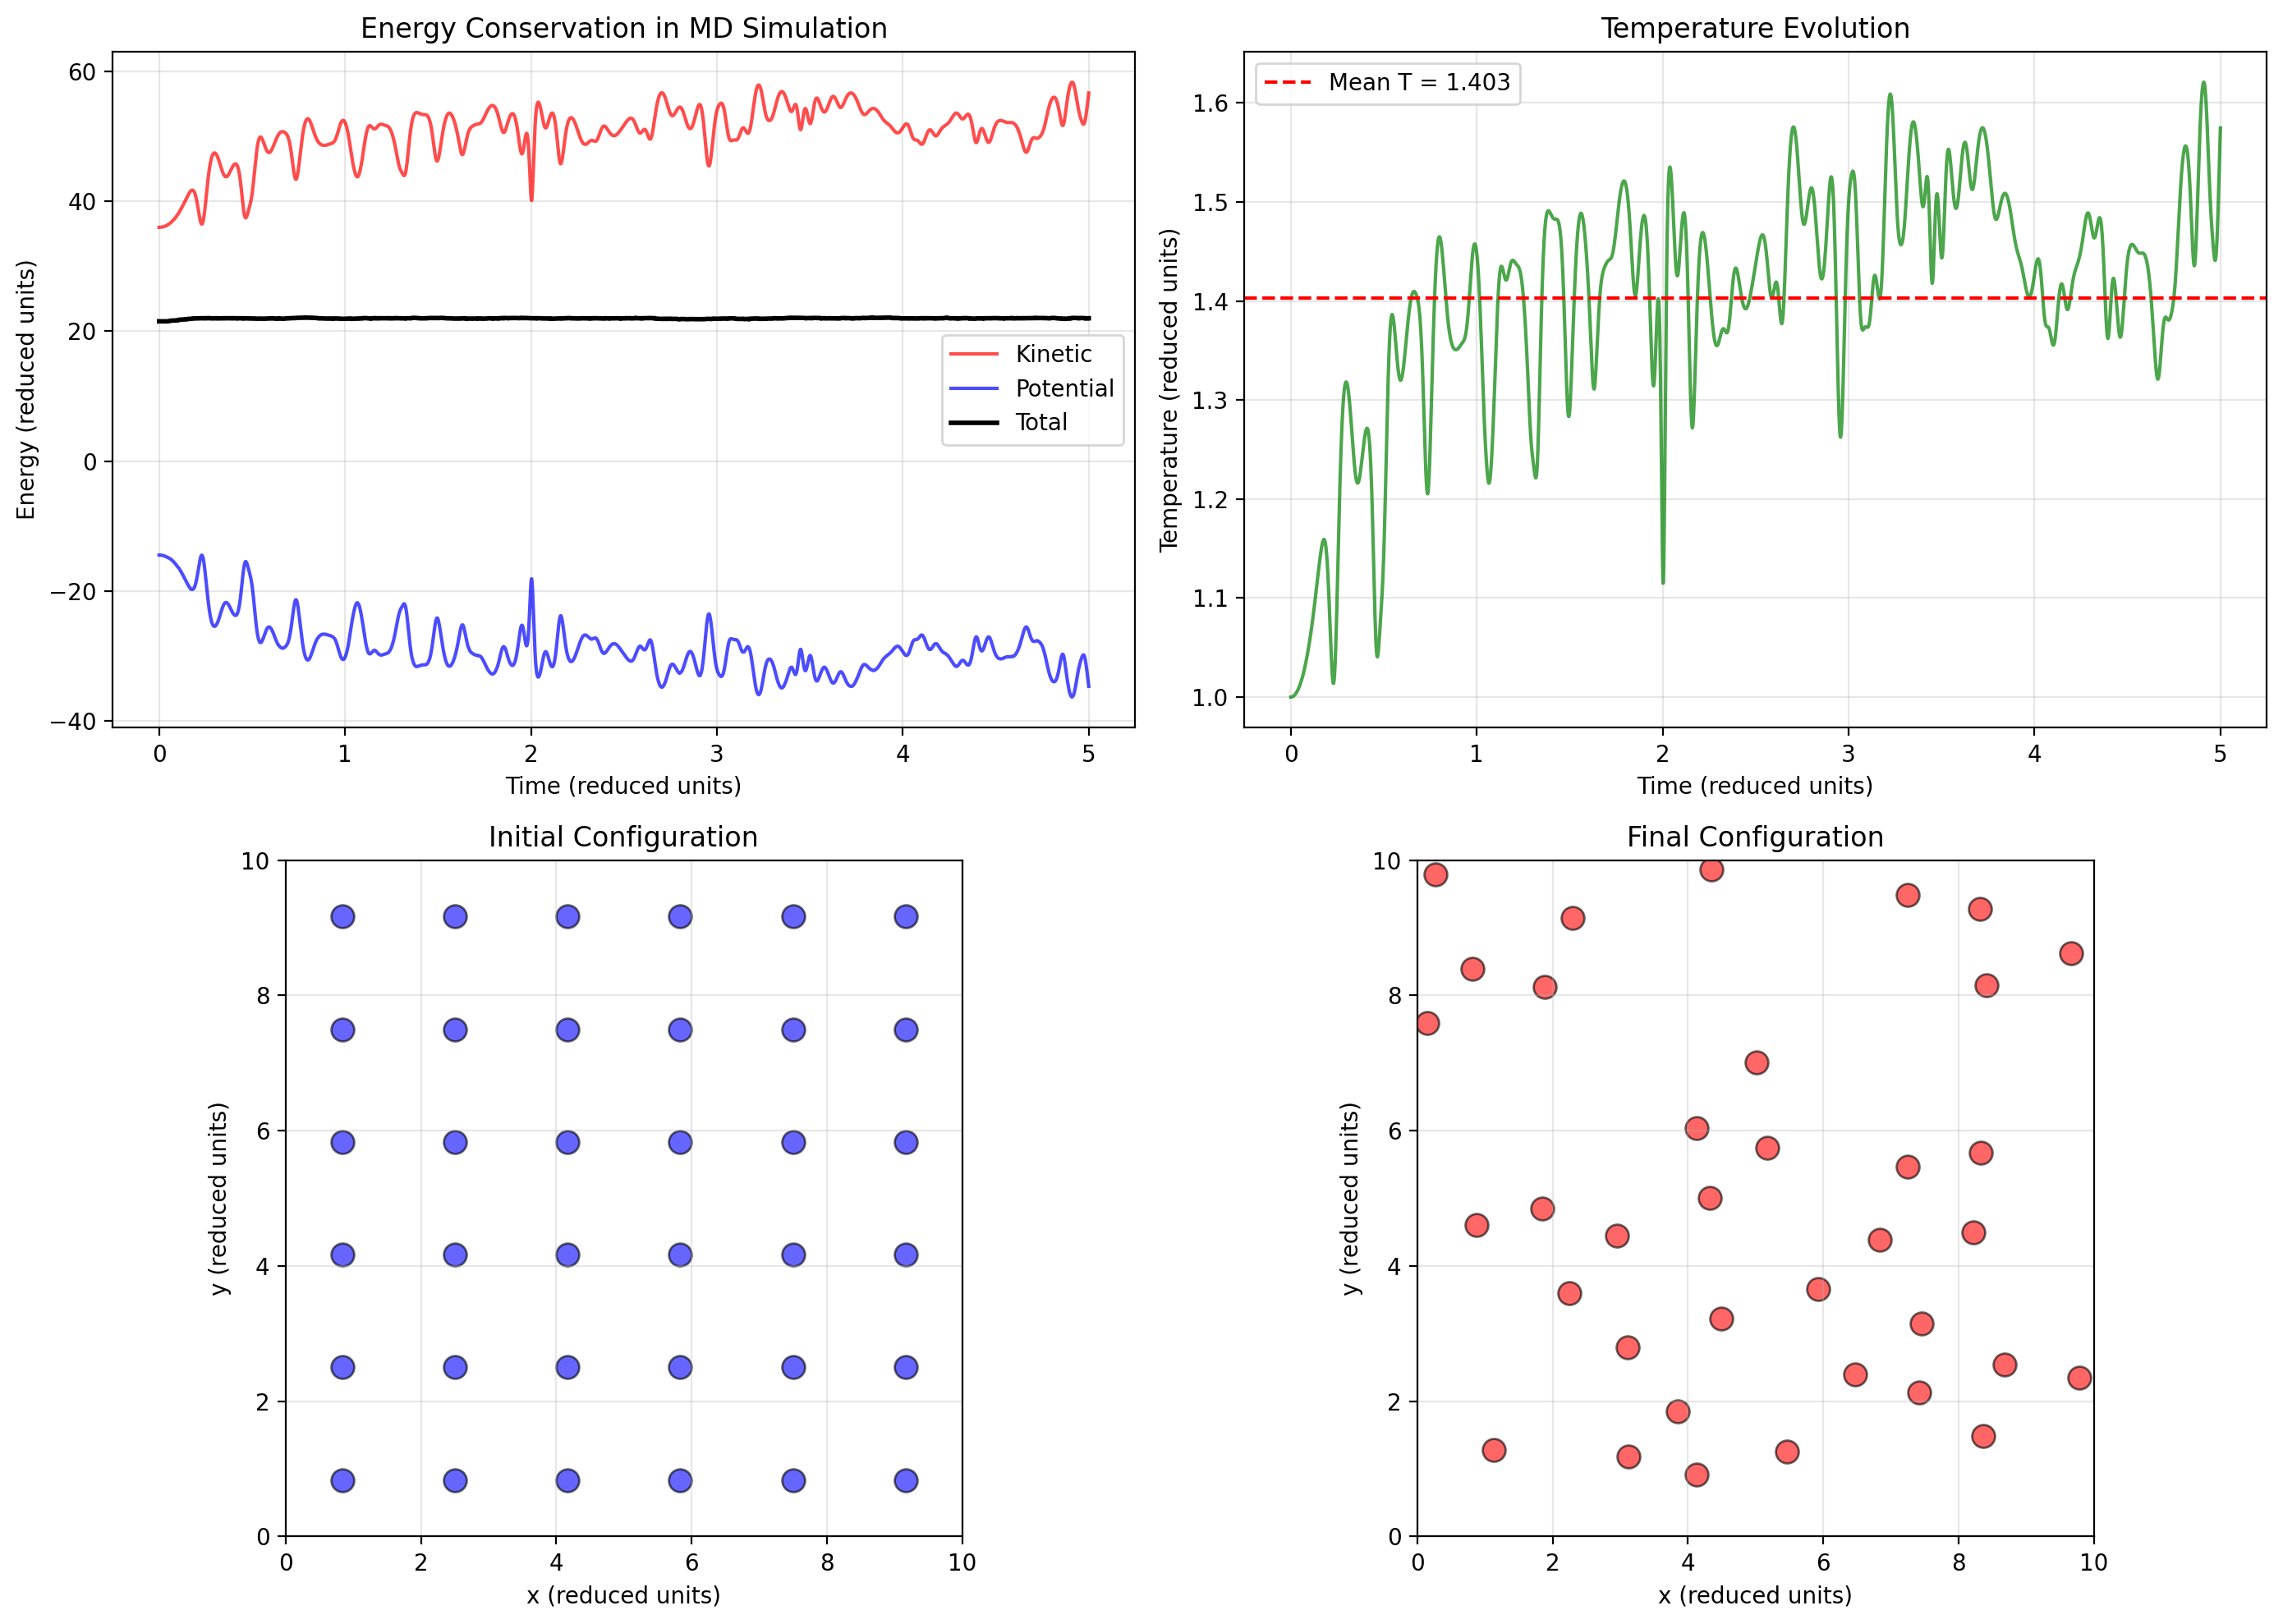


Plot saved as 'plot.png'


In [7]:
# Convert to arrays for easier manipulation
times = np.array(times)
kinetic_energies = np.array(kinetic_energies)
potential_energies = np.array(potential_energies)
total_energies = np.array(total_energies)
temperatures = np.array(temperatures)

# Create figure with multiple subplots
fig = plt.figure(figsize=(14, 10))

# Energy plot
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(times, kinetic_energies, 'r-', label='Kinetic', alpha=0.7)
ax1.plot(times, potential_energies, 'b-', label='Potential', alpha=0.7)
ax1.plot(times, total_energies, 'k-', label='Total', linewidth=2)
ax1.set_xlabel('Time (reduced units)')
ax1.set_ylabel('Energy (reduced units)')
ax1.set_title('Energy Conservation in MD Simulation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Temperature plot
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(times, temperatures, 'g-', alpha=0.7)
ax2.axhline(y=np.mean(temperatures), color='r', linestyle='--', 
            label=f'Mean T = {np.mean(temperatures):.3f}')
ax2.set_xlabel('Time (reduced units)')
ax2.set_ylabel('Temperature (reduced units)')
ax2.set_title('Temperature Evolution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Initial configuration
ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(trajectory[0][:, 0], trajectory[0][:, 1], s=100, c='blue', alpha=0.6, edgecolors='black')
ax3.set_xlim(0, box_size)
ax3.set_ylim(0, box_size)
ax3.set_aspect('equal')
ax3.set_xlabel('x (reduced units)')
ax3.set_ylabel('y (reduced units)')
ax3.set_title('Initial Configuration')
ax3.grid(True, alpha=0.3)

# Final configuration
ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(trajectory[-1][:, 0], trajectory[-1][:, 1], s=100, c='red', alpha=0.6, edgecolors='black')
ax4.set_xlim(0, box_size)
ax4.set_ylim(0, box_size)
ax4.set_aspect('equal')
ax4.set_xlabel('x (reduced units)')
ax4.set_ylabel('y (reduced units)')
ax4.set_title('Final Configuration')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('molecular_dynamics_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'plot.png'")

## Analysis and Discussion

### Energy Conservation

The total energy should remain approximately constant throughout the simulation, demonstrating the symplectic nature of the Velocity Verlet integrator. Small fluctuations are acceptable, but significant drift indicates numerical instability (usually from too large a time step).

### Temperature Fluctuations

In the microcanonical (NVE) ensemble, temperature fluctuates around its mean value. The magnitude of fluctuations scales as $1/\sqrt{N}$, so larger systems show more stable temperatures.

### System Evolution

The particles evolve from their initial lattice positions to a more disordered state characteristic of a fluid or gas phase (depending on density and temperature). The Lennard-Jones potential creates both attractive and repulsive interactions that govern this dynamics.

### Extensions

This basic MD simulation can be extended with:
- Neighbor lists for O(N) scaling
- Thermostats (Nosé-Hoover, Berendsen) for canonical ensemble
- Barostats for NPT ensemble
- More sophisticated potentials (EAM, MEAM for metals)
- Radial distribution function analysis

In [8]:
# Summary statistics
print("=" * 50)
print("SIMULATION SUMMARY")
print("=" * 50)
print(f"Number of particles: {N_particles}")
print(f"Box size: {box_size} x {box_size}")
print(f"Number density: {N_particles / box_size**2:.4f}")
print(f"Time step: {dt}")
print(f"Total simulation time: {n_steps * dt}")
print(f"\nEnergy Statistics:")
print(f"  Initial E_total: {total_energies[0]:.4f}")
print(f"  Final E_total: {total_energies[-1]:.4f}")
print(f"  Energy drift: {(total_energies[-1] - total_energies[0]) / abs(total_energies[0]) * 100:.4f}%")
print(f"  Std(E_total): {np.std(total_energies):.6f}")
print(f"\nTemperature Statistics:")
print(f"  Mean T: {np.mean(temperatures):.4f}")
print(f"  Std(T): {np.std(temperatures):.4f}")
print(f"  Min T: {np.min(temperatures):.4f}")
print(f"  Max T: {np.max(temperatures):.4f}")

SIMULATION SUMMARY
Number of particles: 36
Box size: 10.0 x 10.0
Number density: 0.3600
Time step: 0.001
Total simulation time: 5.0

Energy Statistics:
  Initial E_total: 21.5202
  Final E_total: 21.9920
  Energy drift: 2.1925%
  Std(E_total): 0.075491

Temperature Statistics:
  Mean T: 1.4028
  Std(T): 0.1199
  Min T: 1.0000
  Max T: 1.6209
